<a href="https://www.bigdatauniversity.com"><img src = "https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width = 400, align = "center"></a>

<h1 align=center><font size = 5> Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2018-10-05 18:04:47--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2018-10-05 18:04:48 (11.9 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following packages will be UPDATED:

    seaborn: 0.8.0-py35h15a2772_0 --> 0.9.0-py35_0 anaconda

seaborn-0.9.0- 100% |################################| Time: 0:00:00  47.75 MB/s


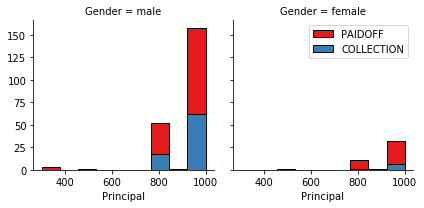

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

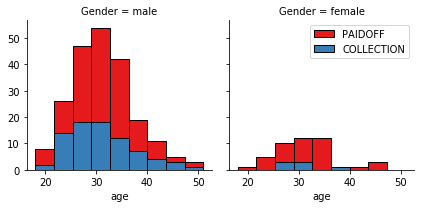

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

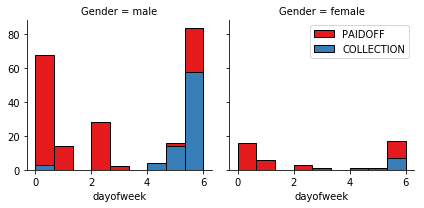

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [65]:
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split( X, y, test_size=0.2, random_state=4)

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import f1_score

In [68]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_trainset,y_trainset)
    knn_pred=neigh.predict(X_testset)
    mean_acc[n-1] = metrics.accuracy_score(y_testset, knn_pred)
    std_acc[n-1]=np.std(knn_pred==y_testset)/np.sqrt(knn_pred.shape[0])
    #print("f1-score :: ",f1_score( y_testset, knn_pred, average='weighted'))

print(mean_acc)
knnbest = mean_acc.argmax()+1
print("Best Accuracy is with neighbor ",knnbest)
print("Best Accuracy is ",mean_acc.max())

[ 0.67142857  0.65714286  0.71428571  0.68571429  0.75714286  0.71428571
  0.78571429  0.75714286  0.75714286]
Best Accuracy is with neighbor  7
Best Accuracy is  0.785714285714


In [73]:
# F1 SCORE AND JACCARD SCORE FOR KNN WITH 7 NEIGBOURS
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
neigh = KNeighborsClassifier(n_neighbors = 7).fit(X_trainset,y_trainset)
knn_pred=neigh.predict(X_testset)
print("F1-SCORE:: ",f1_score( y_testset, knn_pred, average='weighted'))
print("JACCARD SIMILARITY SCORE:: ",jaccard_similarity_score(y_testset, knn_pred))

F1-SCORE::  0.776654024442
JACCARD SIMILARITY SCORE::  0.785714285714


# Decision Tree

In [21]:
!conda install -c anaconda pydotplus -y

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    pydotplus: 2.0.2-py35_0 anaconda

pydotplus-2.0. 100% |################################| Time: 0:00:00  25.14 MB/s


In [22]:
# Import 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [23]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)


In [24]:
# Print the shape of X_trainset and y_trainset. Ensure that the dimensions match
print("X-trainset-shape:: ", X_trainset.shape)
print("Y-trainset-shape:: ", y_trainset.shape) 

X-trainset-shape::  (242, 8)
Y-trainset-shape::  (242,)


In [25]:
loanTree = DecisionTreeClassifier(criterion="entropy",max_depth=6)
loanTree # SHOWS DEFAULT PARAMS

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [26]:
# train the model on training set 
loanTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

---

##### Prediction

In [27]:
predTree = loanTree.predict(X_testset)

##### Printing out predTree and y_testset to visually compare the prediction to the actual values.


In [28]:
# Lets see the Output of 5 results
print ("PREDICTED -- >", predTree [0:10])
print ("ACTUAL --> ", y_testset [0:10])

PREDICTED -- > ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
ACTUAL -->  ['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'COLLECTION'
 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF']


#### Evaluation
##### Next, let's import metrics from sklearn and check the accuracy of our model.

In [29]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.701923076923


#### Jaccard Score

In [30]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score( y_testset, predTree)

0.70192307692307687

##### F1 SCORE

In [31]:
from sklearn.metrics import f1_score
f1_score( y_testset, predTree, average='weighted')

0.70007256894049352

#### Visualization

In [32]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline


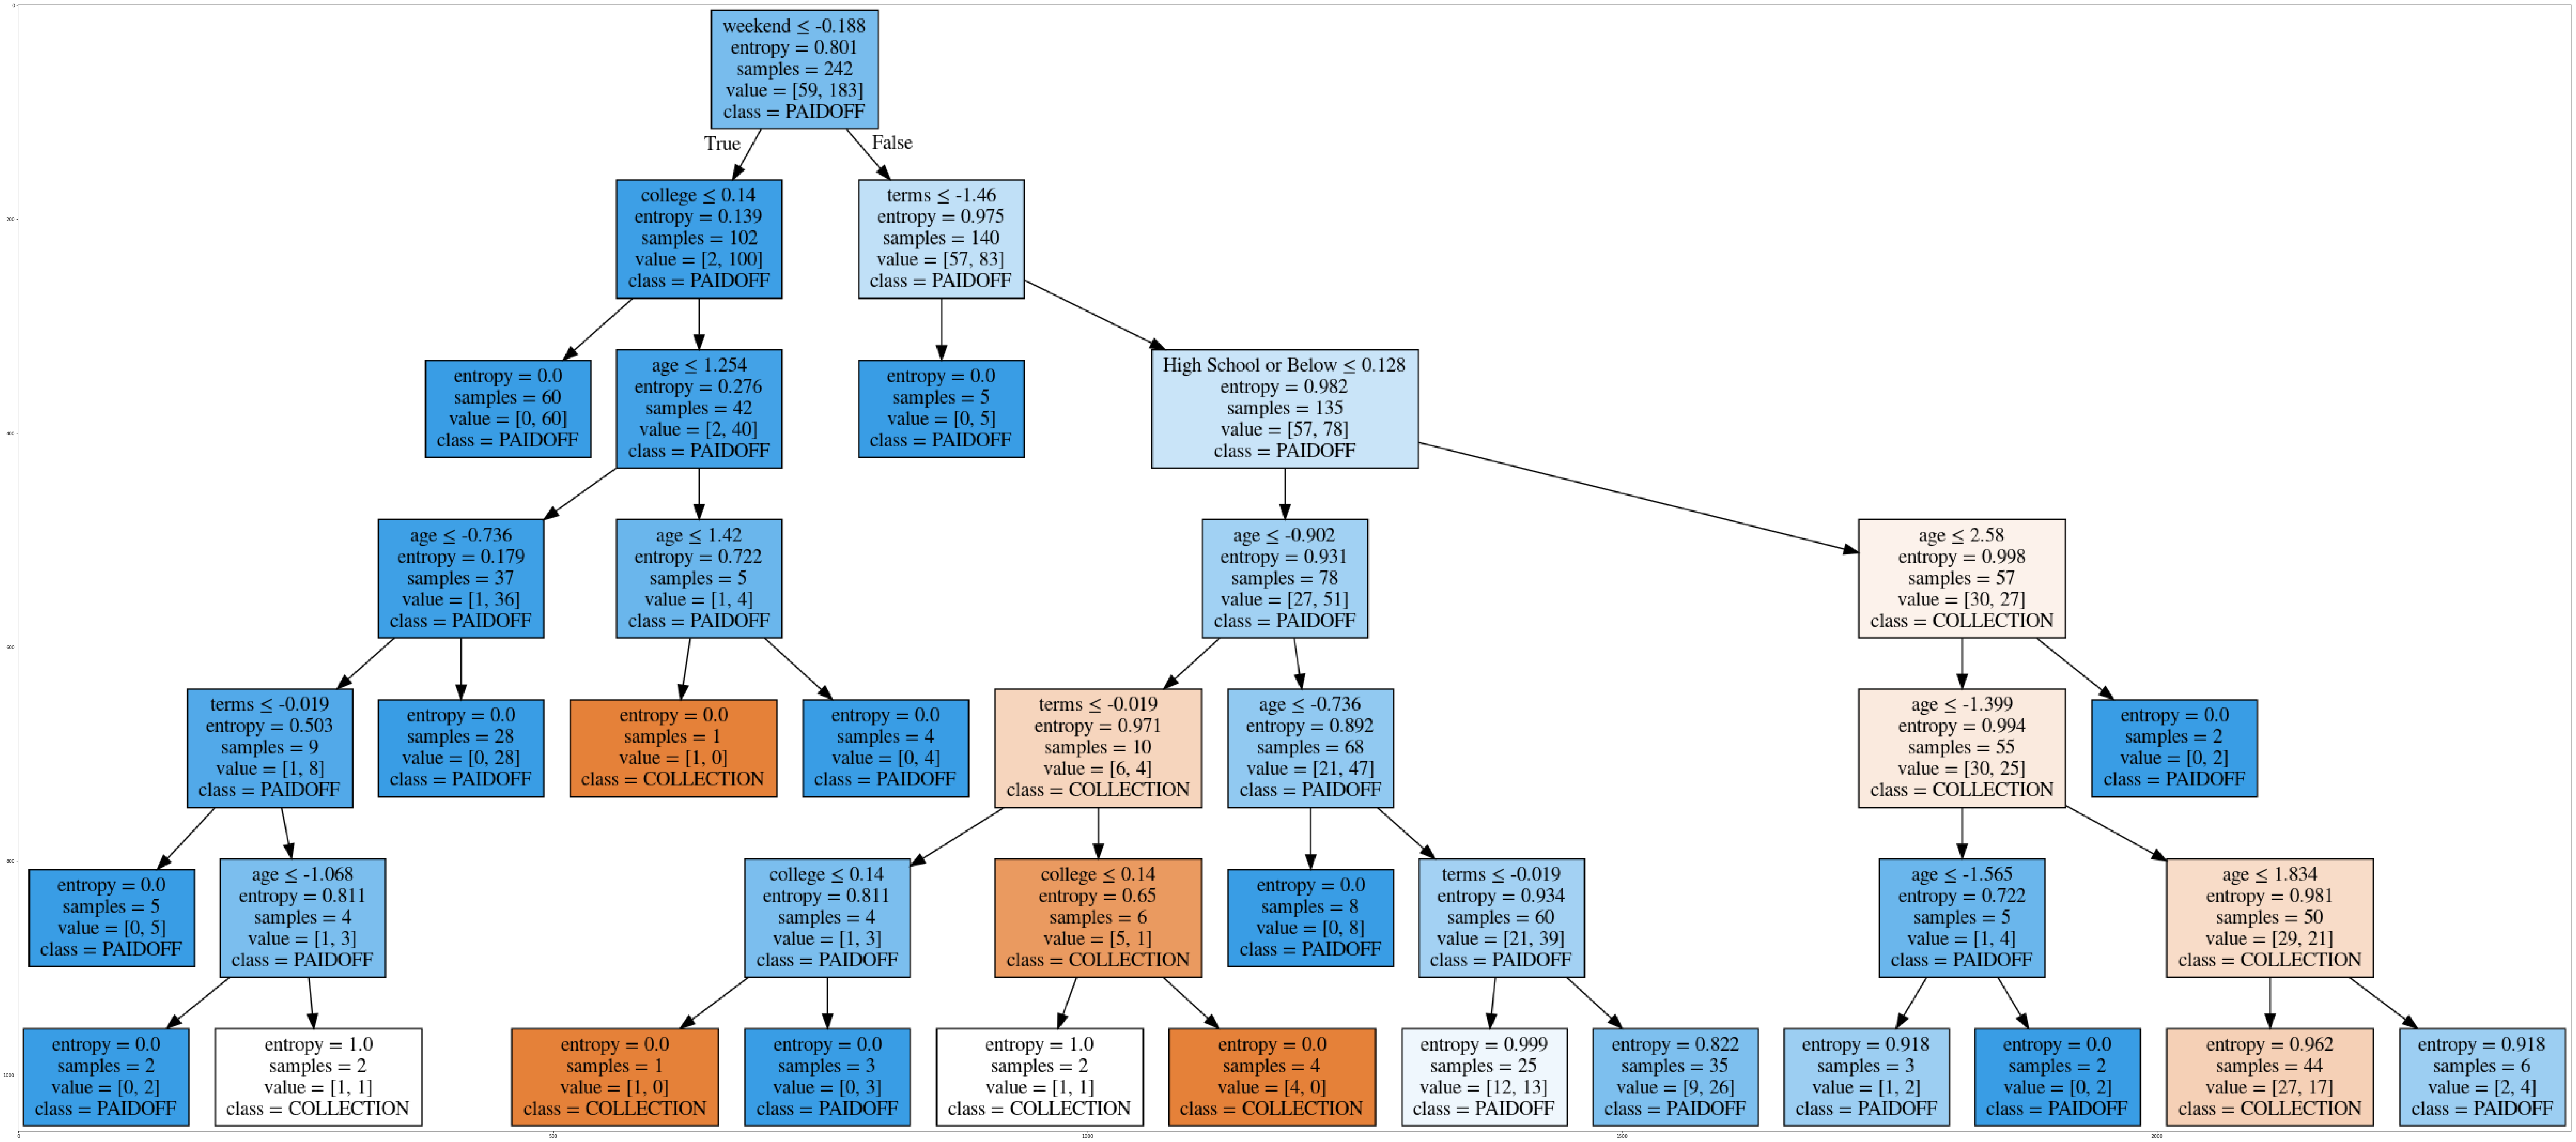

In [33]:
dot_data = StringIO()
filename = "loantree.png"
featureNames = Feature.columns[:]
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

In [54]:
# SVM
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split( X, y, test_size=0.2, random_state=4)

from sklearn import svm

knls = ['linear', 'rbf', 'sigmoid']
mean_accuracy = np.zeros((len(knls)))
for kernel in knls:
    clf = svm.SVC(kernel=kernel)
    clf.fit(X_trainset, y_trainset)
    svm_predict = clf.predict(X_testset)
    mean_accuracy[knls.index(kernel)] = metrics.accuracy_score(y_testset, svm_predict)

print( "The best accuracy was :: ", mean_accuracy.max())

The best accuracy was ::  0.785714285714


##### FOR RBF::

In [55]:

from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split( X, y, test_size=0.2, random_state=4)

from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_trainset, y_trainset) 

svm_pred = clf.predict(X_testset)
svm_pred [0:5]

from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_testset, svm_pred)

0.74285714285714288

##### FOR LINEAR::

In [57]:
# SVM
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split( X, y, test_size=0.2, random_state=4)

from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_trainset, y_trainset) 

svm_pred = clf.predict(X_testset)
svm_pred [0:5]

from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_testset, svm_pred)

0.7857142857142857

##### FOR SIGMOID::

In [52]:
# SVM
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split( X, y, test_size=0.2, random_state=4)

from sklearn import svm
clf = svm.SVC(kernel='sigmoid')
clf.fit(X_trainset, y_trainset) 

svm_pred = clf.predict(X_testset)
svm_pred [0:5]

from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_testset, svm_pred)

0.74285714285714288

# Logistic Regression

In [40]:
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_trainset.shape,  y_trainset.shape)
print ('Test set:', X_testset.shape,  y_testset.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_trainset,y_trainset)
LR
lr_predict = LR.predict(X_testset)
lr_predict

from sklearn.metrics import jaccard_similarity_score
print("Jaccard Score :: ",jaccard_similarity_score(y_testset, lr_predict) )


from sklearn.metrics import f1_score
print("F1 Score :: ",f1_score(y_testset, lr_predict, average='weighted'))


Jaccard Score ::  0.685714285714
F1 Score ::  0.667052246


In [45]:
lr_prob = LR.predict_proba(X_testset)
lr_prob

array([[ 0.5034238 ,  0.4965762 ],
       [ 0.45206111,  0.54793889],
       [ 0.30814132,  0.69185868],
       [ 0.34259428,  0.65740572],
       [ 0.32025894,  0.67974106],
       [ 0.31680537,  0.68319463],
       [ 0.48830185,  0.51169815],
       [ 0.47823073,  0.52176927],
       [ 0.34259428,  0.65740572],
       [ 0.4934056 ,  0.5065944 ],
       [ 0.33806706,  0.66193294],
       [ 0.49662231,  0.50337769],
       [ 0.24891907,  0.75108093],
       [ 0.3419095 ,  0.6580905 ],
       [ 0.43751789,  0.56248211],
       [ 0.25760497,  0.74239503],
       [ 0.52357188,  0.47642812],
       [ 0.30450278,  0.69549722],
       [ 0.50166363,  0.49833637],
       [ 0.3195971 ,  0.6804029 ],
       [ 0.44276988,  0.55723012],
       [ 0.49410185,  0.50589815],
       [ 0.51350333,  0.48649667],
       [ 0.47203498,  0.52796502],
       [ 0.40944694,  0.59055306],
       [ 0.50846442,  0.49153558],
       [ 0.51098415,  0.48901585],
       [ 0.37457647,  0.62542353],
       [ 0.50418423,

In [46]:
from sklearn.metrics import log_loss
log_loss(y_testset, lr_prob)

0.57722876094796538

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.785   | 0.777    | NA      |
| Decision Tree      | 0.701   | 0.700    | NA      |
| SVM                | 0.786   | 0.786    | NA      |
| LogisticRegression | 0.686   | 0.667    | 0.577   |

### This completes the course!

#### Thank You!